# NYC Rideshare Exploratory Analysis Notebook

This notebook explores the validated trip data to better understand demand patterns. Data is aggregated to daily zone-level totals then analyzed for weekly, seasonal, and correlation patterns. Zone volume is evaluated to determine an appropriate dataset size for modeling. Outliers are flagged using IQR-based detection. The dataset characteristics will inform feature engineering and model selection in the next notebook (03_demand_forecasting.ipynb).

**Pipeline Position:** Notebook 3 of 4 — Exploratory Analysis

- 00_data_download.ipynb
- 01_data_validation.ipynb
- 02_exploratory_analysis.ipynb ← **this notebook**
- 03_demand_forecasting.ipynb

**Objective:** Analyze zone-level demand patterns, identifying seasonality and zone characteristics that will help inform forecasting model design.

**Technical Approach:**
- Aggregate daily demand by zone using DuckDB
- Analyze temporal patterns (day and week seasonal trends)
- Measure zone correlations 

**Inputs:**
- `data/validated/fhvhv_valid_data_for_eda.parquet` — Validated trips

**Outputs:**
- `data/processed/zone_daily.parquet` — Zone-level daily aggregates (100 zones × 1,096 days)
- `data/processed/zone_metadata.csv` — Zone reference information

**Runtime:** ~20 minutes

#### 1. Set Up Environment

##### 1.1 Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import duckdb
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (8, 4),
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.framealpha': 0.9,
    'grid.alpha': 0.3,
    'axes.grid': True,
    'axes.grid.axis': 'y'
})

print("Libraries imported successfully")

Libraries imported successfully


##### 1.2 Configure Paths

In [3]:
# Set constants
PROJECT_YEARS = [2022, 2023, 2024]
TLC_DATASET = 'fhvhv'
TOP_N_ZONES = 100

# Set file paths
PROJECT_ROOT = Path("..").resolve()
RAW_DIR = PROJECT_ROOT / "data" / "raw"
VALIDATED_DIR = PROJECT_ROOT / "data" / "validated"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

# create input output files 
INPUT_FILE = VALIDATED_DIR / f"{TLC_DATASET}_valid_data_for_eda.parquet"
OUTPUT_FILE = PROCESSED_DIR / "zone_daily.parquet"
ZONE_STATS_FILE = PROCESSED_DIR / "zone_stats_summary.csv"

# Create Directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Config loaded: {INPUT_FILE.name}")

✓ Config loaded: fhvhv_valid_data_for_eda.parquet


##### 1.3 Create Database Connection

In [4]:
# Create DuckDB connection
con = duckdb.connect()
con.execute("SET threads=4")
con.execute("SET preserve_insertion_order=false")
#con.execute("SET enable_progress_bar = true")
#con.execute("SET progress_bar_time = 2000")
print("✓ DuckDB connection established")

✓ DuckDB connection established


---

#### 2. Explore Data and Select Zones
Explores the validated dataset and selects top 100 zones by volume for analysis.

**Time Series Target:** Daily trip counts by zone with supplementary duration and distance metrics. This creates a multivariate time series for each zone that captures demand volume and trip characteristics.

**Fields Used:**
- **pickup_datetime:** Trip timestamp → aggregated to daily index  
- **PULocationID:** Zone identifier (1-263) → renamed to `zone_id`  
- **trip_time:** Duration in seconds → aggregated to daily avg/total minutes  
- **trip_miles:** Distance → aggregated to daily avg/total miles  

See [NYC TLC Data Dictionary](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) for complete documentation.

##### 2.1 Review Dataset Structure

In [13]:
# Query dataset statistics
stats = con.execute(f"""
    SELECT 
        COUNT(*) as rows,
        COUNT(DISTINCT PULocationID) as zones,
        MIN(pickup_datetime) as start_date,
        MAX(pickup_datetime) as end_date
    FROM '{INPUT_FILE}'
""").fetchone()

# Get column count
col_count = len(con.execute(f"DESCRIBE SELECT * FROM '{INPUT_FILE}'").df())

# Display as simple summary
pd.DataFrame({
    'Metric': ['Total Records', 'Unique Zones', 'Columns', 'Start Date', 'End Date'],
    'Value': [f"{stats[0]:,}", stats[1], col_count, str(stats[2])[:10], str(stats[3])[:10]]
})

,Metric,Value
0,Total Records,"683,780,462"
1,Unique Zones,263
2,Columns,24
3,Start Date,2022-01-01
4,End Date,2024-12-31


In [10]:
# Query company breakdown
companies = con.execute(f"""
    SELECT 
        hvfhs_license_num as company,
        COUNT(*) as trips
    FROM '{INPUT_FILE}'
    GROUP BY hvfhs_license_num
    ORDER BY trips DESC
""").df()

companies['pct'] = (companies['trips'] / companies['trips'].sum() * 100).round(1)
companies

,company,trips,pct
0,HV0003,499553891,73.1
1,HV0005,184226571,26.9


In [16]:
# Show columns (key fields: pickup_datetime, PULocationID, trip_time, trip_miles)
print("Key fields for analysis: pickup_datetime, PULocationID, trip_time, trip_miles\n")
con.execute(f"DESCRIBE SELECT * FROM '{INPUT_FILE}'").df()[['column_name', 'column_type']]

Key fields for analysis: pickup_datetime, PULocationID, trip_time, trip_miles



,column_name,column_type
0,hvfhs_license_num,VARCHAR
1,dispatching_base_num,VARCHAR
2,originating_base_num,VARCHAR
3,request_datetime,TIMESTAMP
4,on_scene_datetime,TIMESTAMP
5,pickup_datetime,TIMESTAMP
6,dropoff_datetime,TIMESTAMP
7,PULocationID,BIGINT
8,DOLocationID,BIGINT
9,trip_miles,DOUBLE


##### 2.2 Check for Missing Values

In [17]:
# Check for null values in analysis fields
print("\nNULL VALUE CHECK\n" + "-"*40)

null_check = con.execute(f"""
    SELECT 
        SUM(CASE WHEN pickup_datetime IS NULL THEN 1 ELSE 0 END) as null_pickup_datetime,
        SUM(CASE WHEN PULocationID IS NULL THEN 1 ELSE 0 END) as null_zone,
        SUM(CASE WHEN trip_time IS NULL THEN 1 ELSE 0 END) as null_trip_time,
        SUM(CASE WHEN trip_miles IS NULL THEN 1 ELSE 0 END) as null_trip_miles
    FROM '{INPUT_FILE}'
""").df()

print("Null counts in analysis fields:")
for col in null_check.columns:
    count = null_check[col].iloc[0]
    status = "OK" if count == 0 else "FOUND"
    print(f"  {col}: {count:,} ({status})")


NULL VALUE CHECK
----------------------------------------
Null counts in analysis fields:
  null_pickup_datetime: 0.0 (OK)
  null_zone: 0.0 (OK)
  null_trip_time: 0.0 (OK)
  null_trip_miles: 0.0 (OK)


##### 2.3 Validate Data Completeness
Verifies all zones have data for all 36 months.

**Note:** Monthly check confirms no major coverage gaps. Daily gaps within months are handled below.

In [ ]:
# Check for  complete 36-month time series coverage
print("DATE COMPLETENESS CHECK\n" + "-"*40)

# Query database to count distinct months and total trips per zone
zone_completeness = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        COUNT(DISTINCT DATE_TRUNC('month', pickup_datetime)) as months_present,
        COUNT(*) as total_trips
    FROM '{INPUT_FILE}'
    GROUP BY PULocationID
    ORDER BY months_present, total_trips DESC
""").df()

# Define expected number of months based on analysis period
expected_months = 36  # 2022-2024 = 3 years

# Split zones into complete (usable) vs incomplete (exclude) based on month count
incomplete_zone_ids = zone_completeness[zone_completeness['months_present'] < expected_months]
complete_zone_ids = zone_completeness[zone_completeness['months_present'] == expected_months]['zone_id'].tolist()

# Print summary statistics and list of incomplete_zone_ids zones
print(f"Expected months: {expected_months}")
print(f"Zones with complete data: {len(complete_zone_ids)}")
print(f"Zones with incomplete data: {len(incomplete_zone_ids)}")

if len(incomplete_zone_ids) > 0:
    print(f"\nIncomplete zones (will not be used in aggregation):")
    print(incomplete_zone_ids.to_string(index=False))

DATE COMPLETENESS CHECK
----------------------------------------
Expected months: 36
Zones with complete data: 260
Zones with incomplete data: 3

Incomplete zones (will not be used in aggregation):
 zone_id  months_present  total_trips
     264               1            1
       1              25           52
     105              33          126


##### 2.4 Analyze Zone Volumes
This section examines how rideshare demand is distributed across NYC's 263 taxi zones.

###### 2.4.1 Calculate Volume Totals

In [22]:
# Calculate total trips and percentages by zone to understand demand distribution across all zones
zone_totals = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        COUNT(*) as total_trips
    FROM '{INPUT_FILE}'
    WHERE PULocationID IN ({','.join(map(str, complete_zone_ids))})
    GROUP BY PULocationID
    ORDER BY total_trips DESC
""").df()

# Calculate percentage of total
zone_totals['pct_of_total'] = (zone_totals['total_trips'] / zone_totals['total_trips'].sum() * 100).round(2)


###### 2.4.2 Visualize Volume Distribution

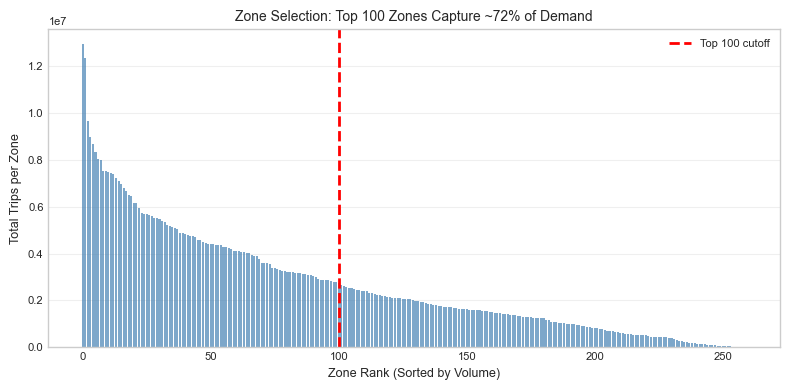

In [23]:
# Visualize zone demand distribution
zone_totals['cumulative_pct'] = zone_totals['pct_of_total'].cumsum()
top_n_pct = zone_totals.iloc[:TOP_N_ZONES]['cumulative_pct'].iloc[-1]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.bar(range(len(zone_totals)), zone_totals['total_trips'], 
        color='steelblue', alpha=0.7)
ax1.axvline(x=TOP_N_ZONES, color='red', linestyle='--', linewidth=2,
            label=f'Top {TOP_N_ZONES} cutoff')
ax1.set_xlabel('Zone Rank (Sorted by Volume)')
ax1.set_ylabel('Total Trips per Zone')
ax1.set_title('Zone Selection: Top 100 Zones Capture ~72% of Demand')
ax1.legend(loc='upper right')
ax1.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Note:** Gradual decline shows demand is fairly evenly distributed across zones, not concentrated in a few hot spots. This would indicate more zones will be neededto capture meaningful coverage (100 zones = ~72% of demand).

###### 2.4.3 Analyze Cumulative Coverage (Pareto)

In [25]:
# Perform pareto analysis to determine cumulative coverage by zone count
print("\nPARETO ANALYSIS\n" + "-"*40)
print("Cumulative trip coverage by zone count:\n")

for n in [10, 20, 30, 50, 75, 100, 150]:
    if n <= len(zone_totals):
        pct = zone_totals.iloc[:n]['cumulative_pct'].iloc[-1]
        marker = " <--" if n == TOP_N_ZONES else ""
        print(f"  Top {n:3d} zones: {pct:5.1f}%{marker}")




PARETO ANALYSIS
----------------------------------------
Cumulative trip coverage by zone count:

  Top  10 zones:  13.5%
  Top  20 zones:  23.7%
  Top  30 zones:  32.1%
  Top  50 zones:  46.5%
  Top  75 zones:  61.3%
  Top 100 zones:  72.5% <--
  Top 150 zones:  87.8%


**Interpretation:** The trip volume seems to follow a distributed pattern rather than classic Pareto concentration (80/20 rule). Capturing 72.5% of trips requires 100 zones, compared to the typical Pareto expectation of ~20 zones for 80% coverage. This distribution justifies a broader zone selection strategy. Focusing only on the top 10-20 zones would miss the majority of rideshare activity. The selected 100 zones provide coverage while remaining manageable for multi-series forecasting. 

The remaining 27.5% of trips are spread across 160+ lower-volume zones where forecasting would be less reliable due to sparse data.

##### 2.5 Select Final Zones
Select top zones capturing ~80% of total demand and save as a list to use during aggregation.

In [26]:
print(f"\nFINAL ZONE SELECTION\n" + "-"*40)

# Filter zone_totals to only zones with complete 36-month coverage
complete_zone_totals = zone_totals[zone_totals['zone_id'].isin(complete_zone_ids)].copy()
print(f"Zones with complete 36-month coverage: {len(complete_zone_totals)}")

# Select the top N zones by trip volume from complete zones
selected_zones = complete_zone_totals.nlargest(TOP_N_ZONES, 'total_trips').reset_index(drop=True)
print(f"Selected for analysis: {len(selected_zones)}")

# Verify the expected number of zones
assert len(selected_zones) == TOP_N_ZONES, \
    f"Expected {TOP_N_ZONES} zones but got {len(selected_zones)}"

#Calculate what percentage of total demand the selected zones represent
coverage_pct = (selected_zones['total_trips'].sum() / zone_totals['total_trips'].sum()) * 100
print(f"\nCoverage: {coverage_pct:.1f}% of all trips")




FINAL ZONE SELECTION
----------------------------------------
Zones with complete 36-month coverage: 260
Selected for analysis: 100

Coverage: 72.5% of all trips


##### 2.6 Validate Daily Completeness
Verifies selected zones have data for all 1,096 days. Time series forecasting requires continuous daily data.

In [28]:
# Verify daily completeness for selected zones
expected_days = 1096  # Jan 1, 2022 to Dec 31, 2024

daily_coverage = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        COUNT(DISTINCT CAST(pickup_datetime AS DATE)) as days_with_data
    FROM '{INPUT_FILE}'
    WHERE PULocationID IN ({','.join(map(str, selected_zones['zone_id'].tolist()))})
    GROUP BY PULocationID
""").df()

min_days = daily_coverage['days_with_data'].min()
zones_complete = (daily_coverage['days_with_data'] == expected_days).all()

print(f"Expected: {expected_days} days (Jan 2022 – Dec 2024)")
print(f"Minimum days per zone: {min_days}")
assert zones_complete, f"Some zones missing daily data"

Expected: 1096 days (Jan 2022 – Dec 2024)
Minimum days per zone: 1096


**Note:** All 100 zones have trips for every day in the 3-year period, confirming the dataset is suitable for daily time series forecasting without imputation.

---

#### 3. Aggregate Daily Demand
Aggregates trip records to daily level by zone for time series analysis.

##### 3.1 Aggregate by Zone and Day

In [29]:
# Aggregate trips by zone and day using only zones with complete time series
print("Aggregating trips to zone-daily level...")

zone_daily = con.execute(f"""
    SELECT 
        CAST(pickup_datetime AS DATE) as date,
        PULocationID as zone_id,
        COUNT(*) as daily_trips,
        ROUND(SUM(trip_time) / 60.0, 1) as daily_total_minutes,
        ROUND(AVG(trip_time) / 60.0, 1) as daily_avg_minutes,
        ROUND(SUM(trip_miles), 1) as total_trip_miles,
        ROUND(AVG(trip_miles), 2) as avg_trip_miles
    FROM '{INPUT_FILE}'
    WHERE PULocationID IN ({','.join(map(str, selected_zones['zone_id'].tolist()))})
    GROUP BY CAST(pickup_datetime AS DATE), PULocationID
    ORDER BY date, zone_id
""").df()

# display head of aggregated data
display(zone_daily.head())


Aggregating trips to zone-daily level...


,date,zone_id,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles
0,2022-01-01,7,6144,89679.4,14.6,29528.5,4.81
1,2022-01-01,13,1505,26165.4,17.4,8352.0,5.55
2,2022-01-01,14,2552,36911.7,14.5,14048.4,5.50
3,2022-01-01,17,4844,74738.9,15.4,20189.2,4.17
4,2022-01-01,18,2797,38208.2,13.7,11795.1,4.22


In [30]:
# Convert zone_id to string (categorical, not numeric)
zone_daily['zone_id'] = zone_daily['zone_id'].astype(str)

# Review with pandas
print("\nAGGREGATION COMPLETE\n" + "-"*40)
print(f"Shape: {zone_daily.shape}")
print(f"\nColumns: {list(zone_daily.columns)}")
print(f"\nSummary:")

print(f"\nDaily Statistics (per zone per day):")
print(zone_daily.describe(include='number').round(2).T.to_string())


AGGREGATION COMPLETE
----------------------------------------
Shape: (109600, 7)

Columns: ['date', 'zone_id', 'daily_trips', 'daily_total_minutes', 'daily_avg_minutes', 'total_trip_miles', 'avg_trip_miles']

Summary:

Daily Statistics (per zone per day):
                        count      mean       std       min       25%       50%        75%        max
daily_trips          109600.0   4520.47   2107.59    449.00   3083.75   3972.00    5282.00   21938.00
daily_total_minutes  109600.0  92847.12  67384.99  11543.00  56350.88  76652.40  105589.48  942108.70
daily_avg_minutes    109600.0     19.61      3.77     12.30     17.40     19.00      20.90      56.80
total_trip_miles     109600.0  23273.50  23629.17   3428.00  13913.60  18464.20   24734.08  341034.90
avg_trip_miles       109600.0      4.83      1.61      2.39      4.11      4.56       5.11      19.85


**Note:** Statistics show high variability across zones.  The daily trips range from 449 to 21,938 with a std of 2,108. This possibly reflects the mix of high-volume Manhattan zones and lower-volume outer borough zones in the top 100.

In [31]:
# VALIDATION: Spot check aggregation against source 
SPOT_CHECK_ZONE = 138
SPOT_CHECK_DATE = '2023-06-15'

agg_value = zone_daily[
    (zone_daily['zone_id'] == str(SPOT_CHECK_ZONE)) & 
    (zone_daily['date'] == SPOT_CHECK_DATE)
]['daily_trips'].values[0]

source_count = con.execute(f"""
    SELECT COUNT(*) as trips
    FROM '{INPUT_FILE}'
    WHERE PULocationID = {SPOT_CHECK_ZONE}
    AND CAST(pickup_datetime AS DATE) = '{SPOT_CHECK_DATE}'
""").fetchone()[0]

assert agg_value == source_count, f"Aggregation mismatch: {agg_value:,} vs {source_count:,}"
print(f"Spot check passed: Zone {SPOT_CHECK_ZONE} on {SPOT_CHECK_DATE} ({agg_value:,} trips)")

Spot check passed: Zone 138 on 2023-06-15 (14,671 trips)


##### 3.2 Create Date Features

In [32]:
# Add time-based features, use pandas since data is small enough

zone_daily['date'] = pd.to_datetime(zone_daily['date'])
zone_daily['year'] = zone_daily['date'].dt.year
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['day_name'] = zone_daily['date'].dt.day_name()
zone_daily['is_weekend'] = zone_daily['day_of_week'].isin([5, 6]).astype(int)

print(f"\nDataset ready for analysis:")
print(f"\nShape: {zone_daily.shape}")
print(f"Memory: {zone_daily.memory_usage(deep=True).sum() / 1e6:.1f} MB")
display(zone_daily.head())


Dataset ready for analysis:

Shape: (109600, 12)
Memory: 19.3 MB


,date,zone_id,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,year,month,day_of_week,day_name,is_weekend
0,2022-01-01,7,6144,89679.4,14.6,29528.5,4.81,2022,1,5,Saturday,1
1,2022-01-01,13,1505,26165.4,17.4,8352.0,5.55,2022,1,5,Saturday,1
2,2022-01-01,14,2552,36911.7,14.5,14048.4,5.50,2022,1,5,Saturday,1
3,2022-01-01,17,4844,74738.9,15.4,20189.2,4.17,2022,1,5,Saturday,1
4,2022-01-01,18,2797,38208.2,13.7,11795.1,4.22,2022,1,5,Saturday,1


 ##### 3.3 Save Aggregated Dataset

In [33]:
# Ensure clean data types before saving
zone_daily['zone_id'] = zone_daily['zone_id'].astype(int)

# Save zone-daily dataset for quick access in later sections
zone_daily.to_parquet(PROCESSED_DIR / "zone_daily.parquet", index=False)
print(f"\nSaved zone-daily dataset: {PROCESSED_DIR / 'zone_daily.parquet'}")


Saved zone-daily dataset: C:\Users\kristi\OneDrive\GitHub Repositories\DataScienceProjects\nyc-fhv-rideshare-forecasting\data\processed\zone_daily.parquet


---

**NOTE** Sections 4-9 use the newly created daily aggregated dataset (100 zones × 1,096 days).

---

#### 4. Analyze Zone Statistics
Calculates volume metrics and distribution shape for each zone.

##### 4.1 Calculate Summary Statistics

In [ ]:
# Calculate summary statistics for each zone 

zone_stats = zone_daily.groupby('zone_id').agg({
    'daily_trips': ['sum', 'mean', 'median', 'std', 'min', 'max'],
    'daily_avg_minutes': 'mean',
    'avg_trip_miles': 'mean'
}).round(2)

# Flatten multi-level column names to single level
zone_stats.columns = ['_'.join(col).strip() for col in zone_stats.columns.values]
zone_stats = zone_stats.reset_index()

#  Calculate coefficient of variation (CV = std/mean)
zone_stats['cv'] = (zone_stats['daily_trips_std'] / zone_stats['daily_trips_mean']).round(3)

# Print basic statistics
print(f"\nBasic Zone Statistics:")
print(f"  Highest average daily demand: {zone_stats['daily_trips_mean'].max():.0f} trips/day")
print(f"  Lowest average daily demand: {zone_stats['daily_trips_mean'].min():.0f} trips/day")
print(f"  Most volatile zone (CV): {zone_stats['cv'].max():.3f}")
print(f"  Most stable zone (CV): {zone_stats['cv'].min():.3f}")

# Display head of zone_stats
display(zone_stats.head())


Calculating zone-level summary statistics...

Basic Zone Statistics:
  Highest average daily demand: 11800 trips/day
  Lowest average daily demand: 2523 trips/day
  Most volatile zone (CV): 0.433
  Most stable zone (CV): 0.113


,zone_id,daily_trips_sum,daily_trips_mean,daily_trips_median,daily_trips_std,daily_trips_min,daily_trips_max,daily_avg_minutes_mean,avg_trip_miles_mean,cv
0,7,6667243,6083.25,5608.0,1376.25,3428,11197,17.55,4.45,0.226
1,13,3168621,2891.08,2916.0,734.24,1076,4469,21.44,5.91,0.254
2,14,3536864,3227.07,3149.0,484.82,1827,5215,18.11,5.29,0.150
3,17,5632763,5139.38,4970.0,963.63,2822,8410,18.64,3.75,0.187
4,18,3027518,2762.33,2710.5,398.75,1413,4575,16.29,4.02,0.144


"**Interpretation:** Demand varies significantly across zones (top zones average 10x more trips than lower-ranked ones), but within each zone, daily demand is stable over time with a CV < 0.3. This within-zone consistency makes individual zones excellent forecasting candidates. 

##### 4.2 Analyze Distribution Shape

In [ ]:
# Calculate skew with scipy
from scipy import stats

skewness_df = zone_daily.groupby('zone_id')['daily_trips'].apply(
    lambda x: stats.skew(x)
).round(3).reset_index(name='skewness')

zone_stats = zone_stats.merge(skewness_df, on='zone_id')

# Classify zones by distribution shape
zone_stats['distribution_type'] = pd.cut(
    zone_stats['skewness'],
    bins=[-np.inf, -0.5, 0.5, np.inf],
    labels=['Left-skewed', 'Symmetric', 'Right-skewed']
)

print(f"\nDistribution Shape Analysis:")
print(f"  Right-skewed zones (skew > 0.5): {(zone_stats['skewness'] > 0.5).sum()}")
print(f"  Symmetric zones (-0.5 ≤ skew ≤ 0.5): {((zone_stats['skewness'] >= -0.5) & (zone_stats['skewness'] <= 0.5)).sum()}")
print(f"  Left-skewed zones (skew < -0.5): {(zone_stats['skewness'] < -0.5).sum()}")
print(f"  Mean skewness: {zone_stats['skewness'].mean():.3f}")


Distribution Shape Analysis:
  Right-skewed zones (skew > 0.5): 42
  Symmetric zones (-0.5 ≤ skew ≤ 0.5): 57
  Left-skewed zones (skew < -0.5): 1
  Mean skewness: 0.408


**Interpretation:** Right-skewed distributions violate the normality assumption required for z-score outlier detection. IQR-based detection is more appropriate for skewed demand data.

##### 4.3 Visualize Zone Characteristics

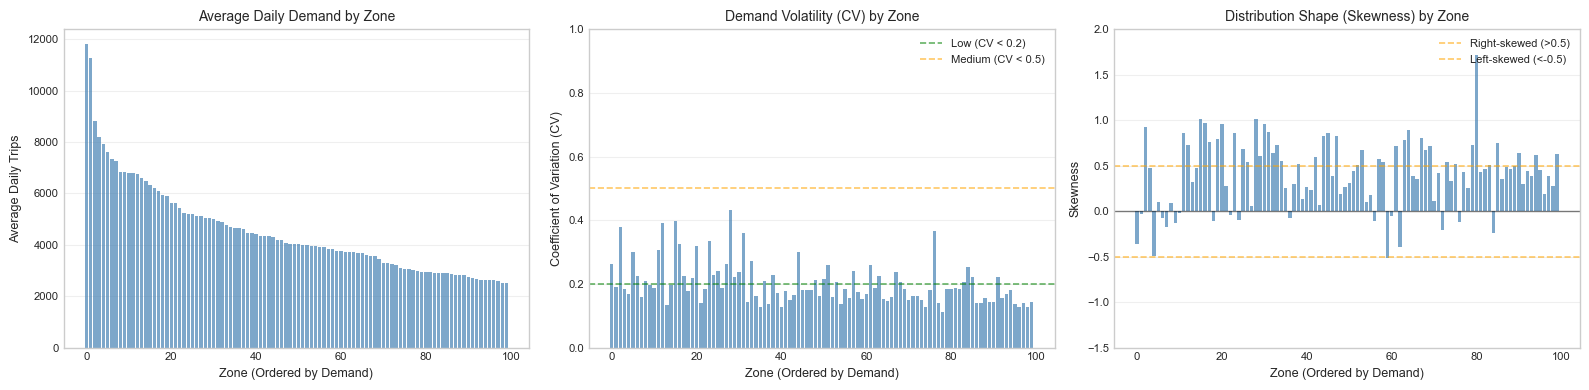

In [38]:
# Create  visualizations of  zone characteristics

# Sort zones by volume for consistent ordering across all panels
zone_stats_sorted = zone_stats.sort_values('daily_trips_mean', ascending=False)

# Create three-panel layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# LEFT: Average Daily Demand
ax1.bar(range(len(zone_stats_sorted)), zone_stats_sorted['daily_trips_mean'], 
        color='steelblue', alpha=0.7)
ax1.set_xlabel('Zone (Ordered by Demand)', fontsize=9)
ax1.set_ylabel('Average Daily Trips', fontsize=9)
ax1.set_title('Average Daily Demand by Zone', fontsize=10)
ax1.grid(True, axis='y', alpha=0.3)

# MIDDLE: Coefficient of Variation
ax2.bar(range(len(zone_stats_sorted)), zone_stats_sorted['cv'], 
        color='steelblue', alpha=0.7)
ax2.axhline(y=0.2, color='green', linestyle='--', linewidth=1.2, alpha=0.6, 
            label='Low (CV < 0.2)')
ax2.axhline(y=0.5, color='orange', linestyle='--', linewidth=1.2, alpha=0.6, 
            label='Medium (CV < 0.5)')
ax2.set_ylim(0, 1.0)
ax2.set_xlabel('Zone (Ordered by Demand)', fontsize=9)
ax2.set_ylabel('Coefficient of Variation (CV)', fontsize=9)
ax2.set_title('Demand Volatility (CV) by Zone', fontsize=10)
ax2.legend(loc='upper right', fontsize=8, framealpha=0.9)
ax2.grid(True, axis='y', alpha=0.3)

# RIGHT: Skewness
ax3.bar(range(len(zone_stats_sorted)), zone_stats_sorted['skewness'], 
        color='steelblue', alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax3.axhline(y=0.5, color='orange', linestyle='--', linewidth=1.2, alpha=0.6, 
            label='Right-skewed (>0.5)')
ax3.axhline(y=-0.5, color='orange', linestyle='--', linewidth=1.2, alpha=0.6, 
            label='Left-skewed (<-0.5)')
ax3.set_ylim(-1.5, 2.0)
ax3.set_xlabel('Zone (Ordered by Demand)', fontsize=9)
ax3.set_ylabel('Skewness', fontsize=9)
ax3.set_title('Distribution Shape (Skewness) by Zone', fontsize=10)
ax3.legend(loc='upper right', fontsize=8, framealpha=0.9)
ax3.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:**
- **Volume** decreases steadily across ranked zones (left)
- **Stability:** Most zones show consistent demand with CV < 0.3 (middle)
- **Skewness:** Most zones are symmetric or right-skewed, indicating occasional high-demand spikes (right)

These patterns would support using robust forecasting methods that handle outliers naturally.

##### 4.4 Save Results

In [39]:
# Save zone statistics
zone_stats.to_csv(PROCESSED_DIR / 'zone_stats_summary.csv', index=False)
print(f"\nSaved zone statistics: {PROCESSED_DIR / 'zone_stats_summary.csv'}")
print(f"  Rows: {len(zone_stats):,}")
print(f"  Columns: {len(zone_stats.columns)}")
print(f"  Metrics: volume, volatility (CV), distribution shape (skewness)")


Saved zone statistics: C:\Users\kristi\OneDrive\GitHub Repositories\DataScienceProjects\nyc-fhv-rideshare-forecasting\data\processed\zone_stats_summary.csv
  Rows: 100
  Columns: 12
  Metrics: volume, volatility (CV), distribution shape (skewness)


---

#### 5. Analyze Demand Patterns
Examines trends, weekly cycles, and annual seasonality in demand.

##### 5.1 Visualize Time Patterns 

In [42]:
# Create time based pattern visualizations showing demand at multiple time scales

# Daily totals for trend analysis
daily_total = zone_daily.groupby('date')['daily_trips'].sum().reset_index()
daily_total.columns = ['date', 'total_trips']

# Day-of-week patterns
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['day_name'] = zone_daily['date'].dt.day_name()
dow_avg = zone_daily.groupby('day_name')['daily_trips'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg['day_name'] = pd.Categorical(dow_avg['day_name'], categories=day_order, ordered=True)
dow_avg = dow_avg.sort_values('day_name')

# Monthly patterns by year
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['month_name'] = zone_daily['date'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_by_year = zone_daily.groupby(['year', 'month_name'])['daily_trips'].mean().reset_index()
monthly_by_year['month_name'] = pd.Categorical(monthly_by_year['month_name'], 
                                                categories=month_order, ordered=True)
monthly_by_year = monthly_by_year.sort_values(['year', 'month_name'])

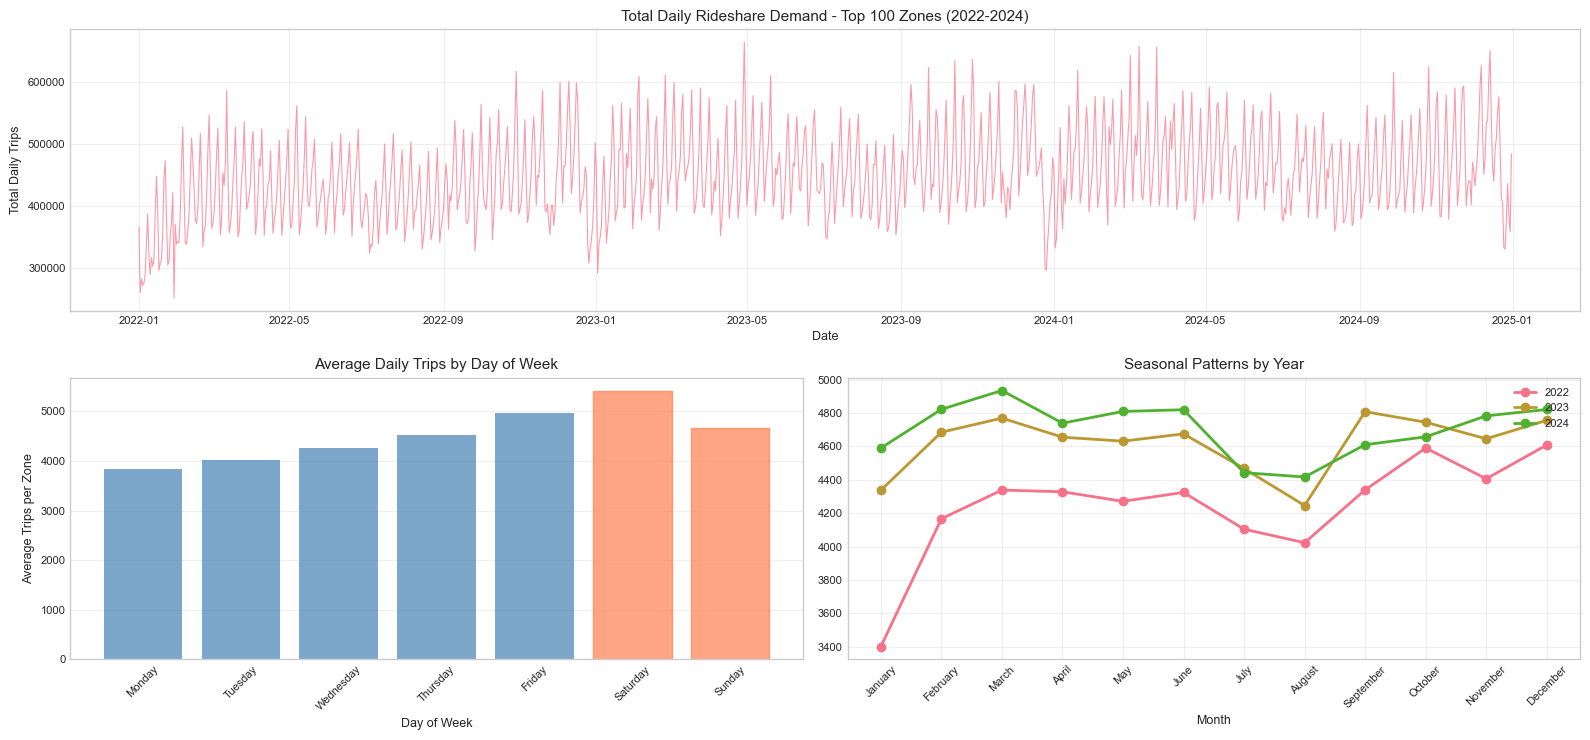

In [44]:
fig = plt.figure(figsize=(16, 7.5))

# TOP ROW: Overall Trend (full width)
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(daily_total['date'], daily_total['total_trips'], linewidth=0.8, alpha=0.7)
ax1.set_title(f'Total Daily Rideshare Demand - Top {TOP_N_ZONES} Zones (2022-2024)', fontsize=11)
ax1.set_xlabel('Date', fontsize=9)
ax1.set_ylabel('Total Daily Trips', fontsize=9)
ax1.grid(True, alpha=0.3)

# BOTTOM LEFT: Day-of-Week Patterns
ax2 = fig.add_subplot(2, 2, 3)
bars = ax2.bar(dow_avg['day_name'], dow_avg['daily_trips'], color='steelblue', alpha=0.7)
bars[5].set_color('coral')  # Saturday
bars[6].set_color('coral')  # Sunday
ax2.set_title('Average Daily Trips by Day of Week', fontsize=11)
ax2.set_xlabel('Day of Week', fontsize=9)
ax2.set_ylabel('Average Trips per Zone', fontsize=9)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, axis='y', alpha=0.3)

# BOTTOM RIGHT: Monthly Patterns by Year
ax3 = fig.add_subplot(2, 2, 4)
for year in [2022, 2023, 2024]:
    year_data = monthly_by_year[monthly_by_year['year'] == year]
    ax3.plot(year_data['month_name'], year_data['daily_trips'], 
             marker='o', linewidth=2, label=str(year))

ax3.set_title('Average Daily Trips by Month (by Year)', fontsize=11)
ax3.set_xlabel('Month', fontsize=9)
ax3.set_title('Seasonal Patterns by Year', fontsize=11)
ax3.tick_params(axis='x', rotation=45)
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:**
- **Trend:** Strong growth in 2022 (possiblu post-COVID recovery), then stabilizes at ~450-550K daily trips in 2023-2024
- **Weekly:** Weekend peaks (Saturday highest) 
- **Seasonal:** Summer lows (July-August) and January dips appear consistently across all three years, both in the trend line and monthly breakdown, confirming reliable seasonality for forecasting

In [46]:
# Quantify weekly pattern
weekday_avg = dow_avg[dow_avg['day_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]['daily_trips'].mean()
weekend_avg = dow_avg[dow_avg['day_name'].isin(['Saturday', 'Sunday'])]['daily_trips'].mean()
weekly_ratio = weekend_avg / weekday_avg

print(f"Weekend/Weekday ratio: {weekly_ratio:.2f}")
print(f"  → Weekends average {(weekly_ratio - 1) * 100:.0f}% higher demand than weekdays")

Weekend/Weekday ratio: 1.17
  → Weekends average 17% higher demand than weekdays


---

#### 6. Measure Zone Correlations
Compares demand patterns across zones to find shared trends.

#### 6. Evaluate Model Strategy
Analyze zone correlations.  This will help determine if a single global model can capture shared demand patterns, or if zone-specific models may be needed.

 ##### 6.1 Visualize Top Zone Patterns

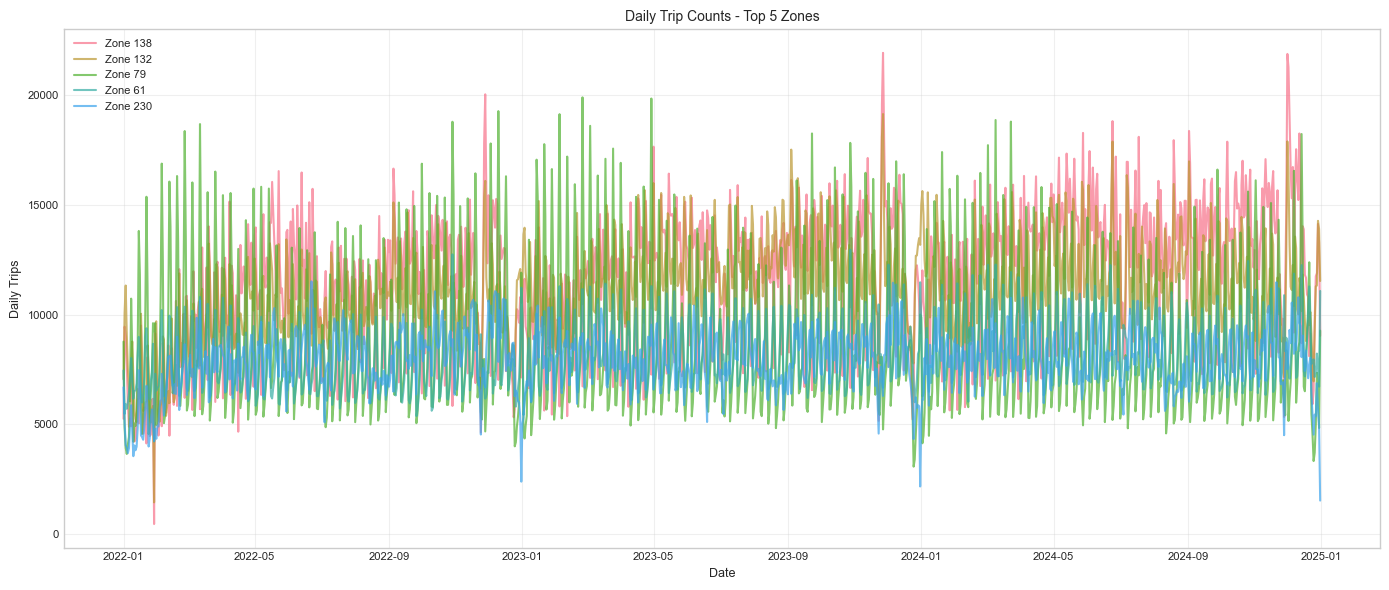

In [47]:
# Select top 5 zones for detailed comparison
top_5_zones = zone_stats.nlargest(5, 'daily_trips_mean')['zone_id'].tolist()

plt.figure(figsize=(14, 6))
for zone_id in top_5_zones:
    zone_ts = zone_daily[zone_daily['zone_id'] == zone_id]
    plt.plot(zone_ts['date'], zone_ts['daily_trips'], label=f'Zone {zone_id}', alpha=0.7)

plt.title('Daily Trip Counts - Top 5 Zones')
plt.xlabel('Date')
plt.ylabel('Daily Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretation:** Top 5 zones show visually similar patterns, rising and falling together. 

 ##### 6.2 Review Zone Correlations

In [49]:
# Calculate zone correlation matrix
zone_pivot = zone_daily.pivot(index='date', columns='zone_id', values='daily_trips')
zone_corr = zone_pivot.corr()

# Extract unique pairs (upper triangle, exclude diagonal)
mask = np.triu(np.ones_like(zone_corr, dtype=bool), k=1)
corr_values = zone_corr.where(mask).stack()

# Summarize correlation distribution
total_pairs = len(corr_values)
corr_summary = pd.DataFrame({
    'Correlation Level': ['High (≥0.7)', 'Medium (0.4–0.7)', 'Low (0–0.4)', 'Negative (<0)'],
    'Zone Pairs': [
        (corr_values >= 0.7).sum(),
        ((corr_values >= 0.4) & (corr_values < 0.7)).sum(),
        ((corr_values >= 0) & (corr_values < 0.4)).sum(),
        (corr_values < 0).sum()
    ]
})
corr_summary['Percentage'] = (corr_summary['Zone Pairs'] / total_pairs * 100).round(1).astype(str) + '%'

print(f"Zone Pair Correlations (n = {total_pairs:,} pairs)\n")
corr_summary

Zone Pair Correlations (n = 4,950 pairs)



,Correlation Level,Zone Pairs,Percentage
0,High (≥0.7),1988,40.2%
1,Medium (0.4–0.7),1756,35.5%
2,Low (0–0.4),824,16.6%
3,Negative (<0),382,7.7%


**Interpretation:** 76% of zone pairs show medium-to-high correlation (≥0.4) This indicaties similar demand patterns which most likely will support using a global model trained on all zones.

---

#### 7. Detect Outliers

##### 7.1 Detect Outliers (IQR Method)


 **IQR Methodology Note:** IQR-based outlier detection was selected based on the low within-zone variability (CV < 0.3). This approach assumes seasonality is not high enough to cause normal seasonal peaks to be misclassified as outliers as seen in section 5.1 visualizations.

 **Modeling Note:** During model evaluation, the residuals should be examined by month to review for seasonality that may need to be addressed. 

In [50]:
# Detect outliers using IQR method - low CV and moderate seasonality make simple approach sufficient

Q1 = zone_daily['daily_trips'].quantile(0.25)
Q3 = zone_daily['daily_trips'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

zone_daily['is_outlier'] = (zone_daily['daily_trips'] < lower_bound) | (zone_daily['daily_trips'] > upper_bound)
outliers = zone_daily[zone_daily['is_outlier']]

pct_outliers = len(outliers) / len(zone_daily) * 100

print("OUTLIER DETECTION (IQR Method)")
print("=" * 50)
print(f"Lower bound:  {lower_bound:,.0f} trips")
print(f"Upper bound:  {upper_bound:,.0f} trips")
print(f"Total records: {len(zone_daily):,}")
print(f"Outliers:      {len(outliers):,} ({pct_outliers:.2f}%)")
print(f"  High demand: {(outliers['daily_trips'] > upper_bound).sum():,}")
print(f"  Low demand:  {(outliers['daily_trips'] < lower_bound).sum():,}")

OUTLIER DETECTION (IQR Method)
Lower bound:  -214 trips
Upper bound:  8,579 trips
Total records: 109,600
Outliers:      5,624 (5.13%)
  High demand: 5,624
  Low demand:  0


**Interpretation:** 
- 5.1% outlier rate confirms data stability. 
- All outliers are high-demand spikes which is consistent with the right-skewed distributions found in Section 4.
-  Outliers are flagged but retained. High-demand days represent legitimate spikes (holidays, events), not errors Tree-based models and Prophet are robust to these values.

---

#### 8. Add Time Features
Add calendar and holiday variable features for modeling.

In [53]:
# Add additional time-based features (year, month, day_of_week, and is_weekend created in Section 3.2)

zone_daily['season'] = zone_daily['month'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'fall', 10: 'fall', 11: 'fall'
})

# Holiday flag
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2022-01-01', end='2024-12-31')
zone_daily['is_holiday'] = zone_daily['date'].isin(holidays)

print("TIME FEATURES ADDED")
print("=" * 40)
print(f"Features: year, month, day_of_week, is_weekend, season, is_holiday")
print(f"Total columns: {len(zone_daily.columns)}")
print(f"Holiday rows flagged: {zone_daily['is_holiday'].sum():,} ({len(holidays)} holidays × 100 zones)")
zone_daily.head()

TIME FEATURES ADDED
Features: year, month, day_of_week, is_weekend, season, is_holiday
Total columns: 16
Holiday rows flagged: 3,200 (32 holidays × 100 zones)


,date,zone_id,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,year,month,day_of_week,day_name,is_weekend,month_name,is_outlier,season,is_holiday
0,2022-01-01,7,6144,89679.4,14.6,29528.5,4.81,2022,1,5,Saturday,True,January,False,winter,False
1,2022-01-01,13,1505,26165.4,17.4,8352.0,5.55,2022,1,5,Saturday,True,January,False,winter,False
2,2022-01-01,14,2552,36911.7,14.5,14048.4,5.50,2022,1,5,Saturday,True,January,False,winter,False
3,2022-01-01,17,4844,74738.9,15.4,20189.2,4.17,2022,1,5,Saturday,True,January,False,winter,False
4,2022-01-01,18,2797,38208.2,13.7,11795.1,4.22,2022,1,5,Saturday,True,January,False,winter,False


#### 9. Save Modeling Dataset


 ##### 9.1 Save Datasets

In [54]:
# Save aggregated zone-daily dataset with time features

zone_daily.to_parquet(PROCESSED_DIR / 'zone_daily.parquet', index=False)
print(f"  Saved: {PROCESSED_DIR / 'zone_daily.parquet'}")
print(f"    Rows: {len(zone_daily):,}")
print(f"    Columns: {len(zone_daily.columns)}")

print(f"\nOutput files ready for Stage 3 (Modeling)")

  Saved: C:\Users\kristi\OneDrive\GitHub Repositories\DataScienceProjects\nyc-fhv-rideshare-forecasting\data\processed\zone_daily.parquet
    Rows: 109,600
    Columns: 16

Output files ready for Stage 3 (Modeling)


---

### Conclusion

This notebook explored demand patterns and seasonality across 683M validated trips. A modeling dataset was created of 109,600 rows (100 zones × 1,096 days).

**Key Findings:**
- The top 100 zones capture ~72% of total demand
- There is weekend-dominant demand (17% higher than weekdays)
- Data shows consistent seasonal pattern across all three years: summer lows, January dips, and fall/winter peaks
- 76% of zone pairs show medium-to-high correlation, supporting a global model approach
- There was strong growth in 2022 (may be post-COVID recovery), then consistent in 2023-2024

**Technical Decisions:**
- Selected top 100 zones by volume to balance coverage with model complexity
- Used IQR method for outlier detection (low within-zone variability made seasonal decomposition unnecessary)
- Engineered 22 features including calendar and holiday flags

**Output Files:**
- `data/processed/zone_daily.parquet` — Zone-level daily aggregates
- `data/processed/zone_metadata.csv` — Zone names and borough mapping

**Next Steps**

Proceed to **03_demand_forecasting.ipynb** to build and evaluate forecasting models.

### Future Work

**Feature Enhancements:**

- Add weather and event data integration
- Add trip length segmentation (short/medium/long)
- Add origin-destination flow analysis